<a href="https://colab.research.google.com/github/Soob00/20251R0136COSE47101/blob/dataset2_employed/dataset2/notebooks/dataset2_SMI_SED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실제 분석 및 과정

# 통계적 차이 검정

- 숫자형 - ANOVA
- 범주형 - 카이제곱

# SMI/SED/진단없음 분석 및 SHAP

## 랜덤포레스트, XGBOOST

### 고려한 점

- (0=해당없음, 1=SMI, 2=SED)

### 앞으로 생각해볼 지점

아마도 feature들로 인해 target(SMI,SED,해당없음)으로 인과관계를 정리해볼 수는 있겠으나 이는 논문 등을 참고해서 진행해야할 것 같음.

현재 분석 결과만으로는 인과관계보다는 상관관계에 가깝다고 보아야함.

### 랜덤포레스트 결과

- 전체변수 포함: 정확도 0.76
    - 정확도는 높으나, 너무 이론적으로 당연한 결고ㅘ

```markdown
### 클래스 0
age, schizoflg, mh1, depressflg, stateip 순.

연령, 조현병 진단 여부, 주진단코드의 여부, 우울증 여부,state 정보가 정신질환에 큰 영향을 줌.

### 클래스 1 (중증 정신질환)

age, educ, detnlf_2, stateip, marstat_4

연령(낮을수록), 교육수준(낮을수록), 경제활동(없을수록), 지역적 차이, 결혼상태(불안정)

### 클래스 2 (심한 정서질환)
mh1, schizoflg, stateip, age, depresflg

SED에 해당하는 특정 진단 코드, 조현병 진단 여부, 거주지, 나이(청소년일수록), 우울증 진단 여부
```

- 진단변수 미포함 : 정확도 0.68
    - 정확도는 조금 낮지만, 더 유의미한 설명이 가능함.
    - 코드 결과는 노션 참고
        

### XGBOOST 결과

- 전체 변수 포함 - 정확도 : 0.85
    - 정확도는 좋지만, 정신질환이 있을 때 더 심한 질환/ 증상을 가지게 된다는 것은 너무 이론적으로 당연한 이야기
- **진단 변수 미포함 - 정확도 : 0.82**
- 코드 결과는 노션참고

# 로지스틱 회귀 분석

SHAP에서 높게 나온 것들 위주로 변수를 선택하고, 그것으로 로지스틱 회귀분석을 진행함.

```markdown

클래스 0, 즉 정신질환이 없는 사람들과 비교했을 때 차이점을 확인함.

### 클래스 1 (SMI-중증 정신질환)
stateip, nummhs, employ, educ, detnlf_2, traustreflg, division_3, race_3 순서로 높게 나타남.

따라서 거주지역, 서비스의 양, 고용 혹은 교육, 인종이 크게 의미를 가진다는 것을 볼 수 있음

SHAP으로 분석한 것과 다르게 연령이 큰 영향을 미치지 않음.

### 클래스 2 (SED-심각한 정서질환)
age, nummhs, employ, educ, detnlf_2, division_8, race_3, stateip, traustreflg 기준으로 높게 나타남

따라서 청소년, 교육ㅇ 부족, 경제활동을 하지 않음, 특정 지역과 연관되어 있을 때 의미를 가짐.

연령이 유의미한 결과를 미침.
회귀분석 결과 또한 아래 결과 혹은 노션 참고

# **STEP1. 통계적 차이 검정**

In [ ]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/단순결측치 행 제거.csv'
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


전체적으로 단순 결측값 데이터셋, 결측값 모두 제거한 데이터셋 두개를 돌렸을 때 SMISED와 각 FEATURE들의 관계성은 비슷하게 나타남.

In [ ]:
# 단순결측치 행 제거로 돌린 통계적 차이 검정

numeric_ = ["AGE", "EDUC", "NUMMHS"]
target = "SMISED"

# 수치형 - ANOVA + Tukey HSD
# t test 보다 anova가 적합함
for variable in numeric_:
    print(f"ANOVA for {variable}")
    model = ols(f"{variable} ~ C({target})", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

    # Tukey HSD - 그룹 사이의 차이를 발견하기
    tukey = pairwise_tukeyhsd(df[variable], df[target])
    print("Tukey HSD:")
    print(tukey)

# 범주형 변수 - 지역변수 및 질병 관려 전부 포험
categorical = [
    "ETHNIC", "RACE", "GENDER", "SPHSERVICE", "CMPSERVICE", "OPISERVICE",
    "RTCSERVICE", "IJSSERVICE", "SUB", "MARSTAT", "SMISED", "EMPLOY",
    "DETNLF", "VETERAN", "LIVARAG", "DIVISION", "REGION", "STATEFIP"
]

# chi-square
for var in categorical:
    print(f"Chi-square test for {var}")
    contingency_table = pd.crosstab(df[var], df[target])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi2: {chi2:.3f}, p-value: {p:.4f}")
    print(contingency_table)


ANOVA for AGE
                  sum_sq         df             F  PR(>F)
C(SMISED)  213562.163671        2.0  1.939641e+06     0.0
Residual   292744.796399  5317607.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.5389   0.0 -0.5395 -0.5382   True
     1      3  -0.1577   0.0 -0.1583 -0.1572   True
     2      3   0.3811   0.0  0.3804  0.3819   True
---------------------------------------------------
ANOVA for EDUC
                 sum_sq         df             F  PR(>F)
C(SMISED)  4.698579e+05        2.0  10263.551572     0.0
Residual   1.217181e+08  5317607.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.7943   0.0 -0.8074 -0.7812   True
     1      3  -0.1142   0.0 -0.

**AGE**	1 < 2 < 3	SMISED 높을수록 나이 증가

**EDUC** 	3번 그룹(중증)의 교육 수준 매우 낮음

**NUMMHS**	서비스 많이 이용한 그룹들이 있어보이나, 그렇게 연관성이 커보이지는 않음

**ETHNIC** 인종/민족으로 차이가 있어보임

**RACE** 인종

**GENDER** 남/녀 비율 다름

**SPHSERVICE** SMISED가 높을수록 이용 증가

**CMPSERVICE**	일부 그룹만 이용

**OPISERVICE**	외래 서비스 차이 큼	접근성 or 서비스 패턴 차이

**RTCSERVICE** 조금 약한데, 그래도 차이 있어보임

**SUB (Substance Use)**	정신질환과 약물 사용 연관성 있음

**MARSTAT (결혼상태)** 미혼 or 이혼 그룹에서 많음

**EMPLOY**	무직 비율이 높음

          SMISED가 높을수록 고용률 낮음

**DETNLF**	경제활동 인구나 노동 참여 관련

**VETERAN**	 군복무 경험 여부

**LIVARAG** 동거 여부

**DIVISION** 지역 간 분포 다름
          
          얘 또한 지역별 차이로, 정책이나 지원을 반영했거나
          우리의 전처리 과정에서의 차이일 수 있을 것

**REGION**	북동/남부 등 차이 존재

          이것 또한 결측치 많은 지역들이 삭제되어 데이터 전체에 영향을 주었을 기능성이 있어 보임

**STATEFIP**	주별 분포 다름	데이터 구조상 영향 큼

          주별로 결측치가 많은 주가 삭제되어서 그런지, 데이터 자체의 차이가 큰 것 같음.
          + 변수 개수 많아 원핫 주의


In [ ]:
print(df.columns.tolist())


['YEAR', 'AGE', 'EDUC', 'ETHNIC', 'RACE', 'GENDER', 'SPHSERVICE', 'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SUB', 'MARSTAT', 'SMISED', 'SAP', 'EMPLOY', 'DETNLF', 'VETERAN', 'LIVARAG', 'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP', 'DIVISION', 'REGION', 'CASEID']


In [ ]:
from google.colab import drive
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
drive.mount('/content/drive')

# 1. 데이터 불러오기
file_path = '/content/drive/MyDrive/결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(df.columns.tolist())


['YEAR', 'AGE', 'EDUC', 'GENDER', 'SPHSERVICE', 'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SAP', 'EMPLOY', 'VETERAN', 'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP', 'CASEID', 'RACE_2', 'RACE_3', 'RACE_4', 'RACE_5', 'RACE_6', 'ETHNIC_2', 'ETHNIC_3', 'ETHNIC_4', 'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4', 'SUB_1', 'SUB_2', 'SUB_3', 'SUB_4', 'SUB_5', 'SUB_6', 'SUB_7', 'SUB_8', 'SUB_9', 'SUB_10', 'SUB_11', 'SUB_12', 'SUB_13', 'MARSTAT_2', 'MARSTAT_3', 'MARSTAT_4', 'SMISED_2', 'SMISED_3', 'DETNLF_2', 'DETNLF_3', 'DETNLF_4', 'DETNLF_5', 'DETNLF_NotApplicable', 'LIVARAG_2', 'LIVARAG_3', 'DIVISION_1', 'DIVISION_2', 'DIVISION_3', 'DIVISION_4', 'DIVISION_5', 'DIVISION_6', 'DIVISION_7', 'DIVISION_8', 'DIVISION_9']


In [ ]:
# 모든 결측치 제거한 데이터셋 활용 분석

numeric_ = ["AGE", "EDUC", "NUMMHS"]
target = "SMISED"

# 수치형 - ANOVA + Tukey HSD
# t test 보다 anova가 적합함
for variable in numeric_:
    print(f"ANOVA for {variable}")
    model = ols(f"{variable} ~ C({target})", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

    # Tukey HSD - 그룹 사이의 차이를 발견하기
    tukey = pairwise_tukeyhsd(df[variable], df[target])
    print("Tukey HSD:")
    print(tukey)

# 범주형 변수 - 지역변수 및 질병 관려 전부 포험
categorical = [
    "ETHNIC", "RACE", "GENDER", "SPHSERVICE", "CMPSERVICE", "OPISERVICE",
    "RTCSERVICE", "IJSSERVICE", "SUB", "MARSTAT", "SMISED", "EMPLOY",
    "DETNLF", "VETERAN", "LIVARAG", "DIVISION", "REGION", "STATEFIP"
]

# chi-square
for var in categorical:
    print(f"Chi-square test for {var}")
    contingency_table = pd.crosstab(df[var], df[target])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi2: {chi2:.3f}, p-value: {p:.4f}")
    print(contingency_table)



ANOVA for AGE
                 sum_sq         df             F  PR(>F)
C(SMISED)   7627.331877        2.0  77138.201968     0.0
Residual   56745.448452  1147778.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.4482   0.0  -0.451 -0.4453   True
     1      3  -0.0824   0.0 -0.0835 -0.0812   True
     2      3   0.3658   0.0  0.3628  0.3687   True
---------------------------------------------------
ANOVA for EDUC
                 sum_sq         df             F  PR(>F)
C(SMISED)   2947.253697        2.0  28502.441533     0.0
Residual   59342.161098  1147778.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.2702   0.0 -0.2731 -0.2673   True
     1      3  -0.0593   0.0 -0.060

# **STEP2~3. SMI/SED/진단 없음 트리기반 분석 및 SHAP**

 (0=해당없음, 1=SMI, 2=SED)

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv("/content/원핫인코딩_결측치가 포함된 모든 행 제거.csv", low_memory=False)

In [ ]:

pd.set_option('display.max_columns', None)
df.head(10)

,YEAR,AGE,EDUC,GENDER,SPHSERVICE,CMPSERVICE,OPISERVICE,RTCSERVICE,IJSSERVICE,MH1,MH2,MH3,SAP,EMPLOY,VETERAN,NUMMHS,TRAUSTREFLG,ANXIETYFLG,ADHDFLG,CONDUCTFLG,DELIRDEMFLG,BIPOLARFLG,DEPRESSFLG,ODDFLG,PDDFLG,PERSONFLG,SCHIZOFLG,ALCSUBFLG,OTHERDISFLG,STATEFIP,CASEID,RACE_2,RACE_3,RACE_4,RACE_5,RACE_6,ETHNIC_2,ETHNIC_3,ETHNIC_4,REGION_1,REGION_2,REGION_3,REGION_4,SUB_1,SUB_2,SUB_3,SUB_4,SUB_5,SUB_6,SUB_7,SUB_8,SUB_9,SUB_10,SUB_11,SUB_12,SUB_13,MARSTAT_2,MARSTAT_3,MARSTAT_4,SMISED_2,SMISED_3,DETNLF_2,DETNLF_3,DETNLF_4,DETNLF_5,DETNLF_NotApplicable,LIVARAG_2,LIVARAG_3,DIVISION_1,DIVISION_2,DIVISION_3,DIVISION_4,DIVISION_5,DIVISION_6,DIVISION_7,DIVISION_8,DIVISION_9,SMISED
0,2022,0.461538,0.50,1,0,1,0,0,0,7,11,-99,1,0.25,0,2,0,0,0,0,0,0,1,0,0,0,1,0,0,1,20220000002,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
1,2022,1.000000,0.75,0,1,1,0,0,0,11,-99,-99,2,0.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,20220000004,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,2022,0.615385,1.00,0,0,1,1,0,0,7,1,2,1,0.00,0,3,1,1,0,0,0,0,1,0,0,0,0,0,0,1,20220000013,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,2022,0.615385,1.00,0,0,1,1,0,0,7,-99,-99,2,1.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,20220000025,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
4,2022,0.846154,0.50,0,0,1,0,0,0,6,-99,-99,1,0.00,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,20220000029,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,2022,0.538462,0.50,1,0,1,0,0,0,6,13,-99,1,0.00,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1,1,20220000031,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
6,2022,0.461538,1.00,0,0,1,0,0,0,2,-99,-99,2,1.00,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,20220000033,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,2
7,2022,0.692308,0.75,0,0,1,0,0,0,7,-99,-99,2,0.25,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,20220000034,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
8,2022,0.384615,0.75,1,0,1,0,0,0,6,-99,-99,2,1.00,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,20220000038,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
9,2022,0.846154,0.75,0,0,1,1,0,0,11,-99,-99,2,0.25,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,20220000040,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
print(df.columns.tolist())

['YEAR', 'AGE', 'EDUC', 'GENDER', 'SPHSERVICE', 'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SAP', 'EMPLOY', 'VETERAN', 'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP', 'CASEID', 'RACE_2', 'RACE_3', 'RACE_4', 'RACE_5', 'RACE_6', 'ETHNIC_2', 'ETHNIC_3', 'ETHNIC_4', 'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4', 'SUB_1', 'SUB_2', 'SUB_3', 'SUB_4', 'SUB_5', 'SUB_6', 'SUB_7', 'SUB_8', 'SUB_9', 'SUB_10', 'SUB_11', 'SUB_12', 'SUB_13', 'MARSTAT_2', 'MARSTAT_3', 'MARSTAT_4', 'SMISED_2', 'SMISED_3', 'DETNLF_2', 'DETNLF_3', 'DETNLF_4', 'DETNLF_5', 'DETNLF_NotApplicable', 'LIVARAG_2', 'LIVARAG_3', 'DIVISION_1', 'DIVISION_2', 'DIVISION_3', 'DIVISION_4', 'DIVISION_5', 'DIVISION_6', 'DIVISION_7', 'DIVISION_8', 'DIVISION_9', 'SMISED']


### **Random Forest 기반, 모든 변수 포함**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.7623


PermutationExplainer explainer: 301it [01:33,  2.94it/s]


None


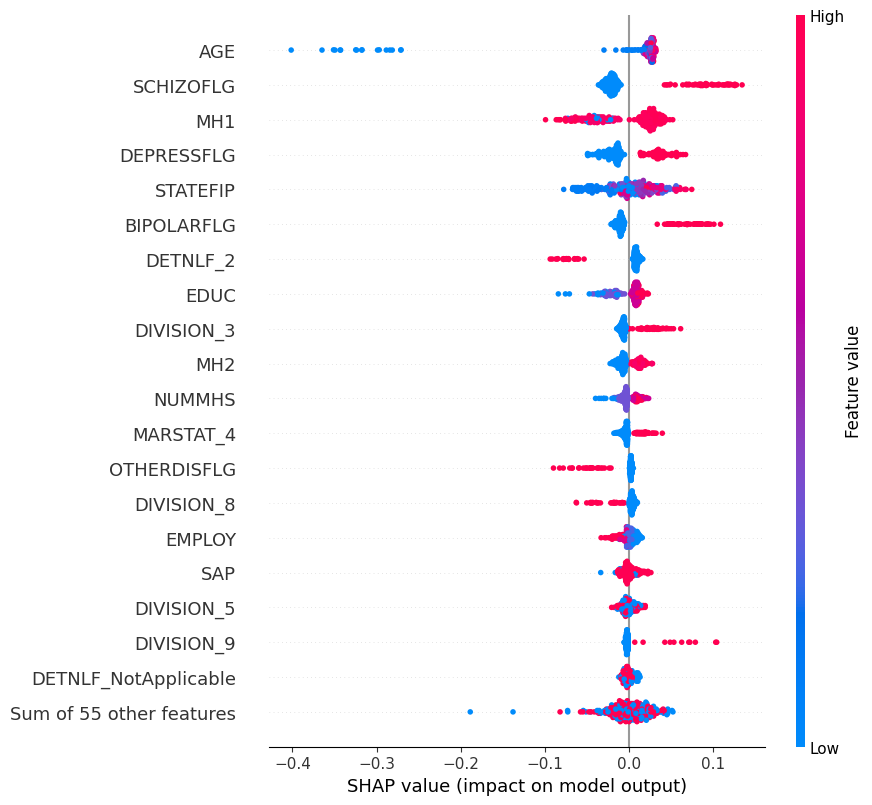

SMI


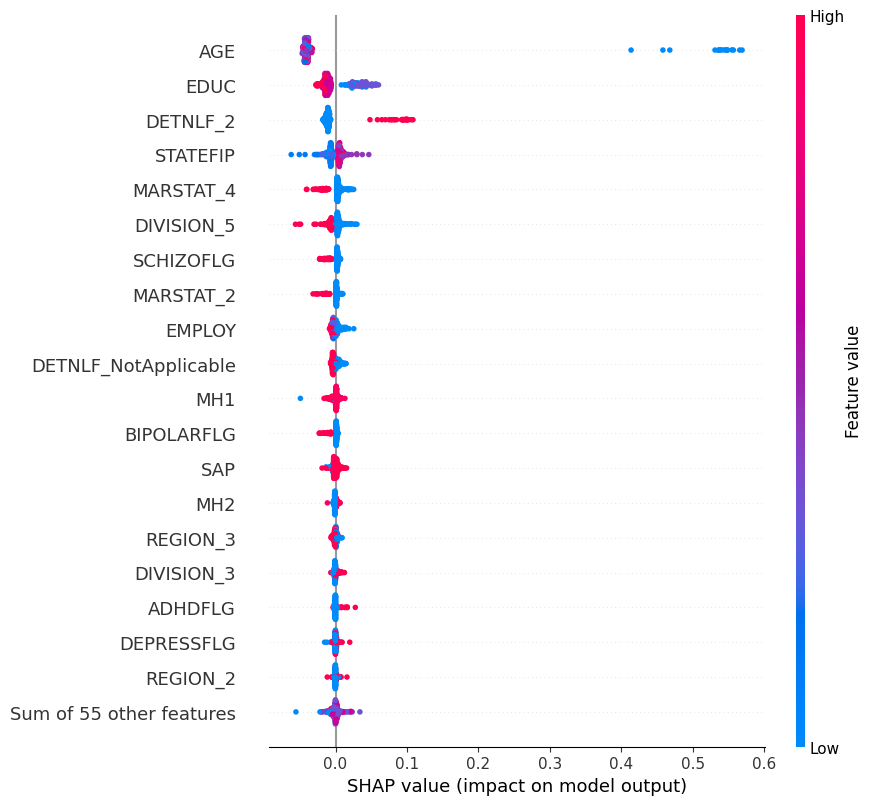

SED


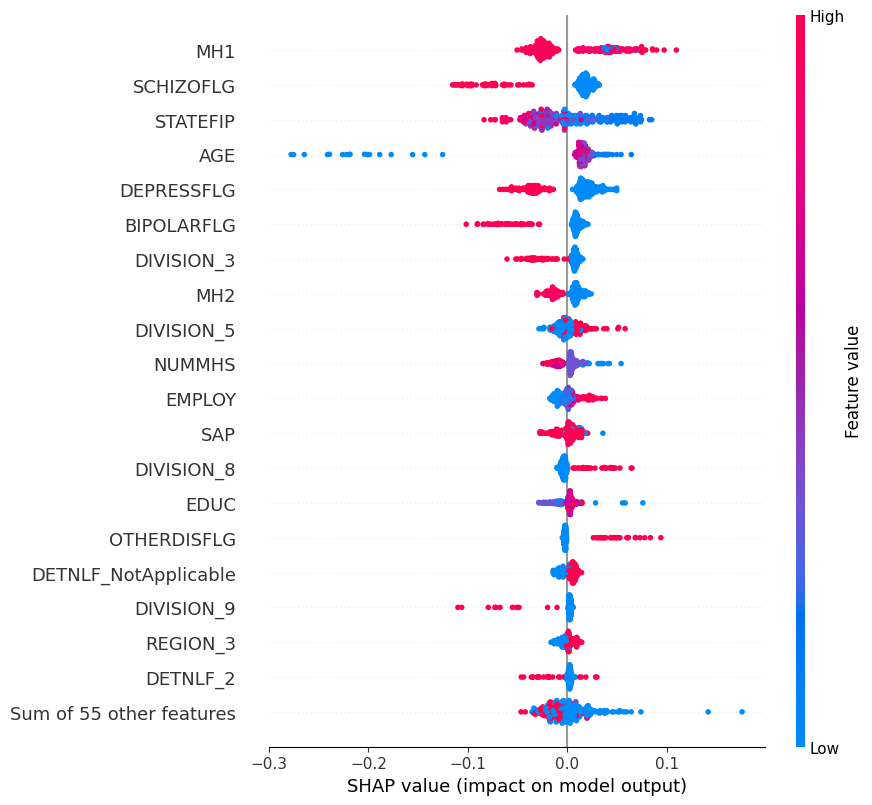

In [ ]:
from google.colab import drive
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

# SMISED 타겟 컬럼 생성 (0=해당없음, 1=SMI, 2=SED)
df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0), axis=1)
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")
X = X.astype(float)

# 랜덤포레스트
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")

# SHAP
X_sample = X.sample(n=300, random_state=42)
def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.Explainer(predict_proba_fn, X_sample)
shap_values = explainer(X_sample)

# 시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(shap_values.values.shape[2]):
    print(f"{class_names.get(i, str(i))}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=["None", "SMI", "SED"]))

              precision    recall  f1-score   support

        None       0.90      0.78      0.84    838304
         SMI       0.67      1.00      0.80     35078
         SED       0.50      0.66      0.57    274399

    accuracy                           0.76   1147781
   macro avg       0.69      0.82      0.74   1147781
weighted avg       0.80      0.76      0.77   1147781



In [ ]:
# 클래스0 증상 없음 SHAP 값
shap_values_class1 = shap_values[:, :, 0].values
df4 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df4.abs().mean().sort_values(ascending=False)
importance.head(10)

,0
AGE,0.041097
SCHIZOFLG,0.034603
MH1,0.033753
DEPRESSFLG,0.025667
STATEFIP,0.024410
BIPOLARFLG,0.020773
DETNLF_2,0.014347
EDUC,0.014234
DIVISION_3,0.011597
MH2,0.010218


In [ ]:
# 클래스1 SMI SHAP 값
shap_values_class1 = shap_values[:, :, 1].values

df2 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df2.abs().mean().sort_values(ascending=False)
print(importance.head(10))


AGE                     0.068796
EDUC                    0.019349
DETNLF_2                0.017696
STATEFIP                0.008107
MARSTAT_4               0.007256
DIVISION_5              0.006452
SCHIZOFLG               0.004508
MARSTAT_2               0.003761
EMPLOY                  0.003646
DETNLF_NotApplicable    0.003412
dtype: float64


In [ ]:
# 클래스2 SED SHAP 값
shap_values_class1 = shap_values[:, :, 2].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

MH1           0.033307
SCHIZOFLG     0.030096
STATEFIP      0.029679
AGE           0.028098
DEPRESSFLG    0.026294
BIPOLARFLG    0.018049
DIVISION_3    0.012790
MH2           0.011657
DIVISION_5    0.008609
NUMMHS        0.008599
dtype: float64


### 클래스 0
age, schizoflg, mh1, depressflg, stateip 순.

연령, 조현병 진단 여부, 주진단코드의 여부, 우울증 여부,state 정보가 정신질환에 큰 영향을 줌.

### 클래스 1 (중증 정신질환)

age, educ, detnlf_2, stateip, marstat_4

연령(낮을수록), 교육수준(낮을수록), 경제활동(없을수록), 지역적 차이, 결혼상태(불안정)

### 클래스 2 (심한 정서질환)
mh1, schizoflg, stateip, age, depresflg

SED에 해당하는 특정 진단 코드, 조현병 진단 여부, 거주지, 나이(청소년일수록), 우울증 진단 여부

## **진단 관련 변수 미포함**

Accuracy: 0.6800


PermutationExplainer explainer: 301it [02:06,  2.20it/s]


None


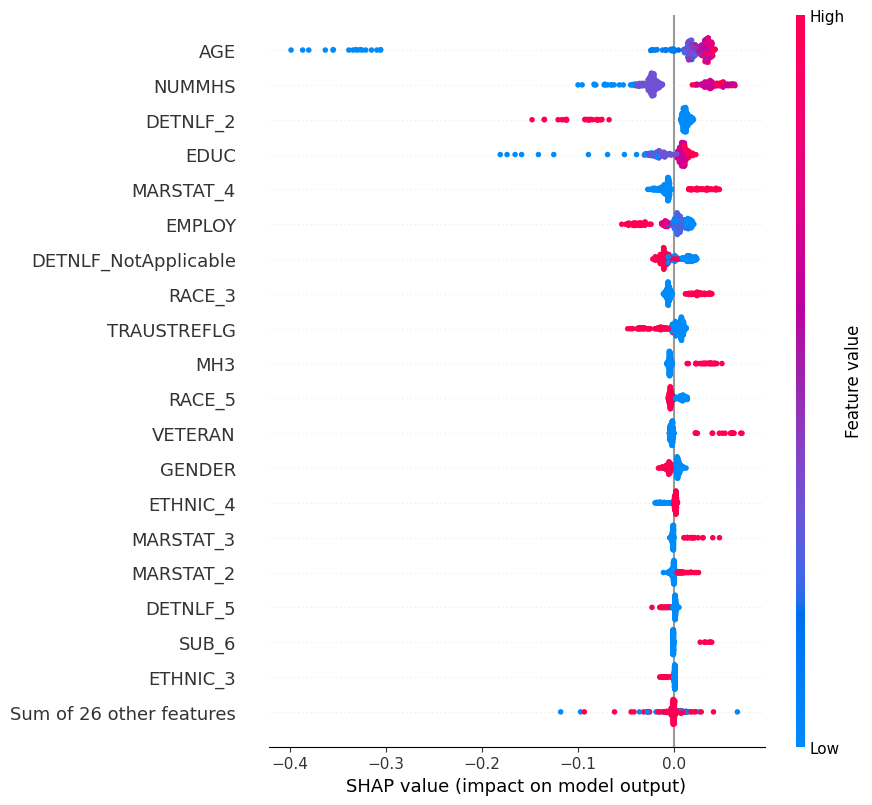

SMI


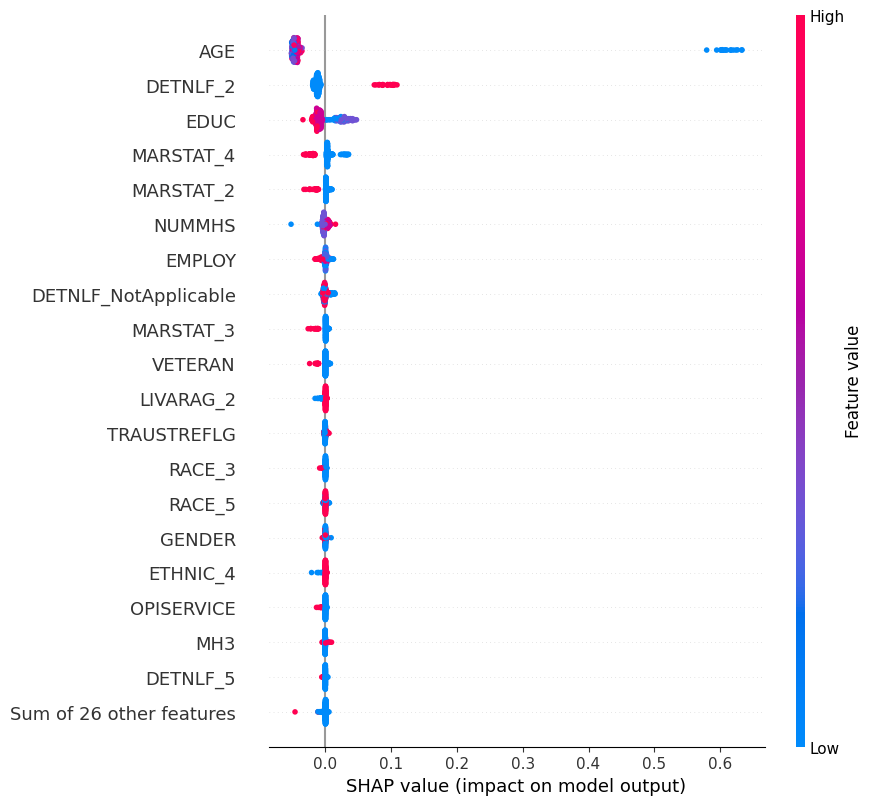

SED


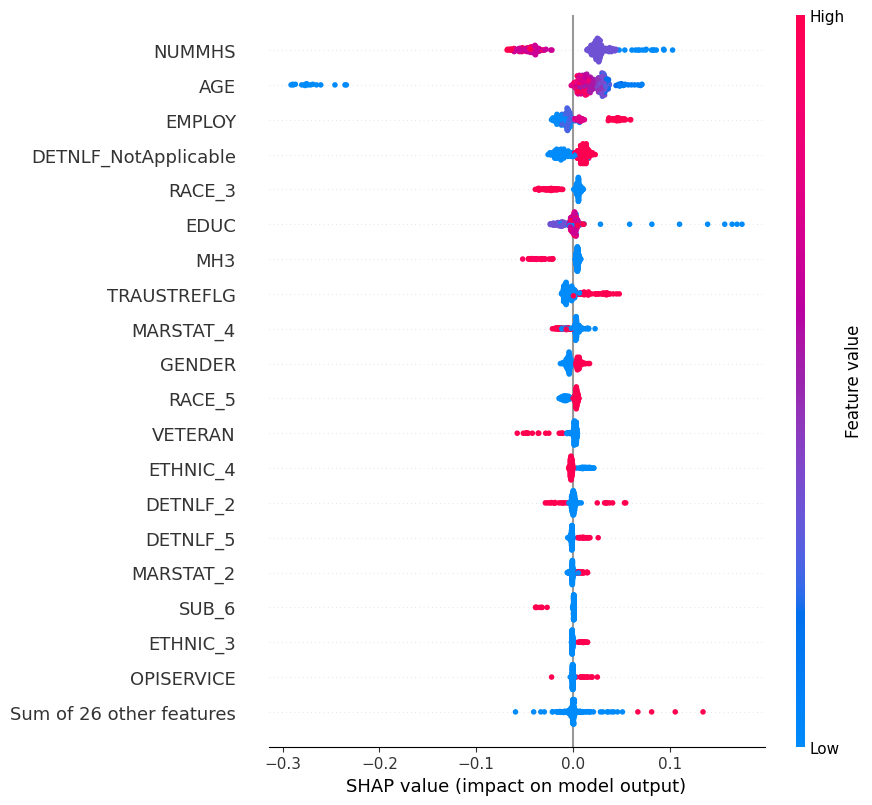

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 진단 관련 변수 제거
diagnosis_vars = [
    'MH1', 'MH2', 'SAP',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG',
    'ALCSUBFLG', 'OTHERDISFLG'
]
df = df.drop(columns=diagnosis_vars, errors='ignore')

# X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")

X = X.astype({col: int for col in X.select_dtypes('bool').columns})

X = X.drop(columns=X.select_dtypes('object').columns)

X = X.astype(float)


# 랜덤포레스트
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# 예측값 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")

# SHAP
X_sample = X.sample(n=300, random_state=42)
def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.Explainer(predict_proba_fn, X_sample)
shap_values = explainer(X_sample)
class_names = {0: "None", 1: "SMI", 2: "SED"}

# 시각화
for i in range(shap_values.values.shape[2]):
    print(f"{class_names.get(i, str(i))}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=["None", "SMI", "SED"]))

              precision    recall  f1-score   support

        None       0.83      0.73      0.78    838304
         SMI       0.63      1.00      0.77     35078
         SED       0.37      0.48      0.42    274399

    accuracy                           0.68   1147781
   macro avg       0.61      0.74      0.66   1147781
weighted avg       0.72      0.68      0.69   1147781



In [ ]:
# 클래스0 해당없음 SHAP 값
shap_values_class1 = shap_values[:, :, 0].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.043930
NUMMHS                  0.032879
DETNLF_2                0.019138
EDUC                    0.015485
MARSTAT_4               0.012620
EMPLOY                  0.012427
DETNLF_NotApplicable    0.010861
RACE_3                  0.010502
TRAUSTREFLG             0.008434
MH3                     0.007898
dtype: float64


In [ ]:
# 클래스1 중증 정신질환(SMI) SHAP 값
shap_values_class1 = shap_values[:, :, 1].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.078229
DETNLF_2                0.019153
EDUC                    0.015755
MARSTAT_4               0.008443
MARSTAT_2               0.003896
NUMMHS                  0.003217
EMPLOY                  0.002407
DETNLF_NotApplicable    0.002199
MARSTAT_3               0.001985
VETERAN                 0.001354
dtype: float64


In [ ]:
# 클래스2 심각한 정서장애(SED) SHAP 값
shap_values_class1 = shap_values[:, :, 2].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

NUMMHS                  0.036015
AGE                     0.035296
EMPLOY                  0.013719
DETNLF_NotApplicable    0.011284
RACE_3                  0.009869
EDUC                    0.008685
MH3                     0.008187
TRAUSTREFLG             0.008069
MARSTAT_4               0.005355
GENDER                  0.005237
dtype: float64


### 클래스0 (정신장애 없음)



### 클래스 0
AGE, NUMMHS, DETNLF_2, EDUC, MARTAT_4

연령(많을수록), NUMMHS(적음), DETNLF_2(양호), EDUC(높음), MARSTAT_4(가족이 안정됨)

### 클래스1 (SMI)
AGE, DETNLF_2, EDUC, MARSTAT_4, MARSTAT_2

연령(낮음), EDUC(낮음), DETNLF_2(실업), MARSTAT - 가족이 불안정함

### 클래스 2 (SED)
NUMMHS, AGE, EMPLOY, DETNLF_NotApplicable, RACE_3

AGE(청소ㅕㄴ층), NUMMHS(서비스 다수 이용), EMPLOY(경제활동 미참여), DETNLF_(고용상태 불안정), RACE_3(인종)

## **지역변수도 함께 제거**

상위 5개만 가지고 확인 중인데, 모두 질환제거했을 때와 항목은 동일

In [ ]:
region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
]

Accuracy: 0.6800


PermutationExplainer explainer: 301it [02:21,  1.97it/s]


None


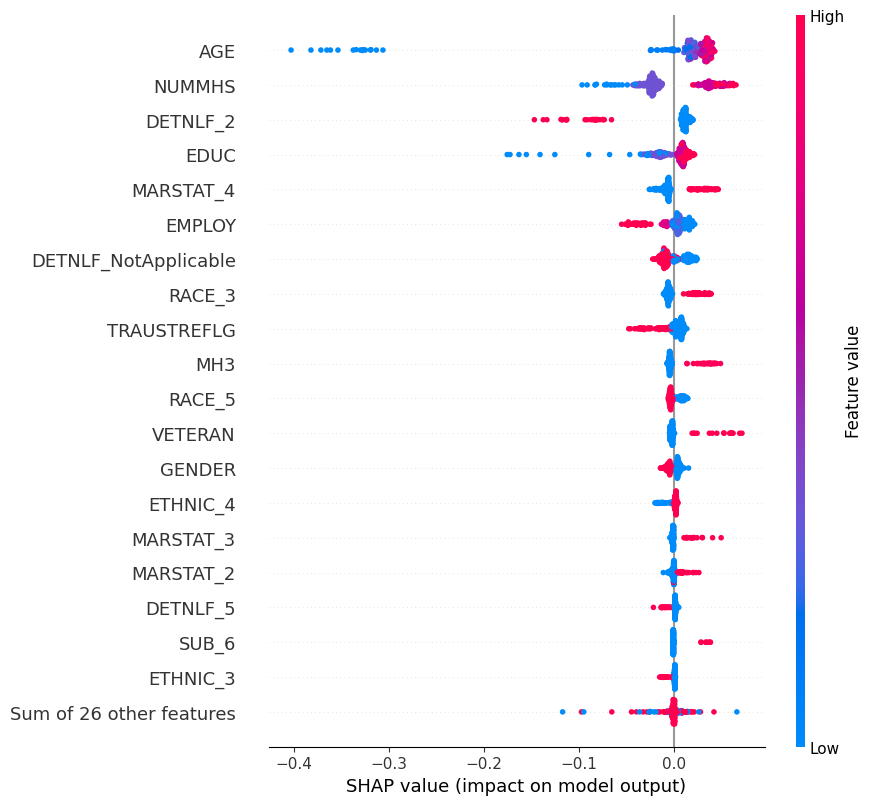

SMI


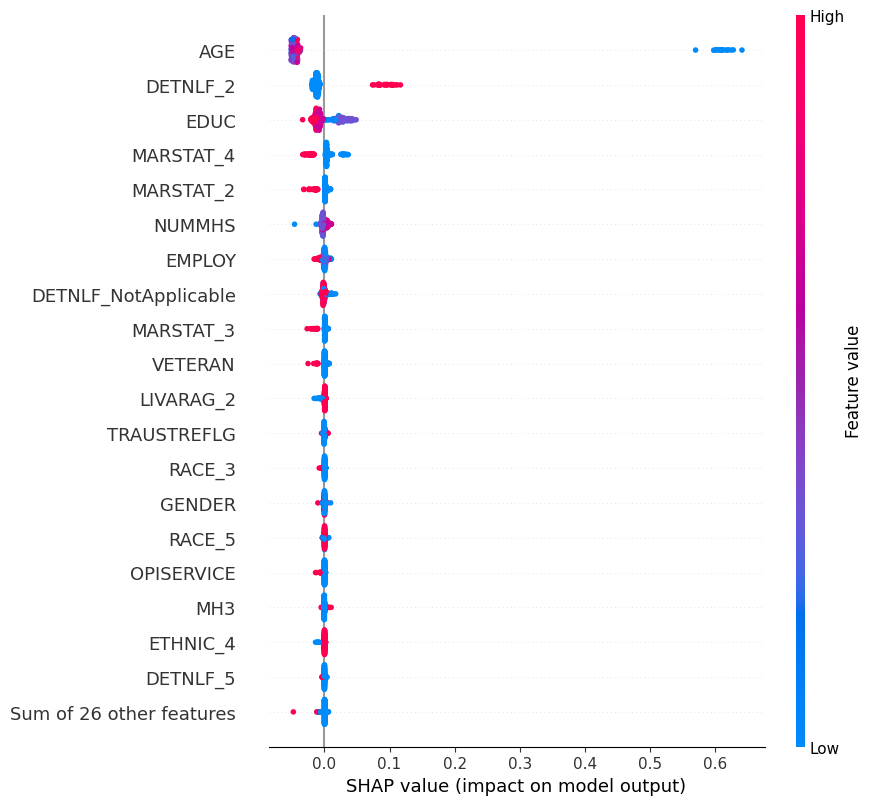

SED


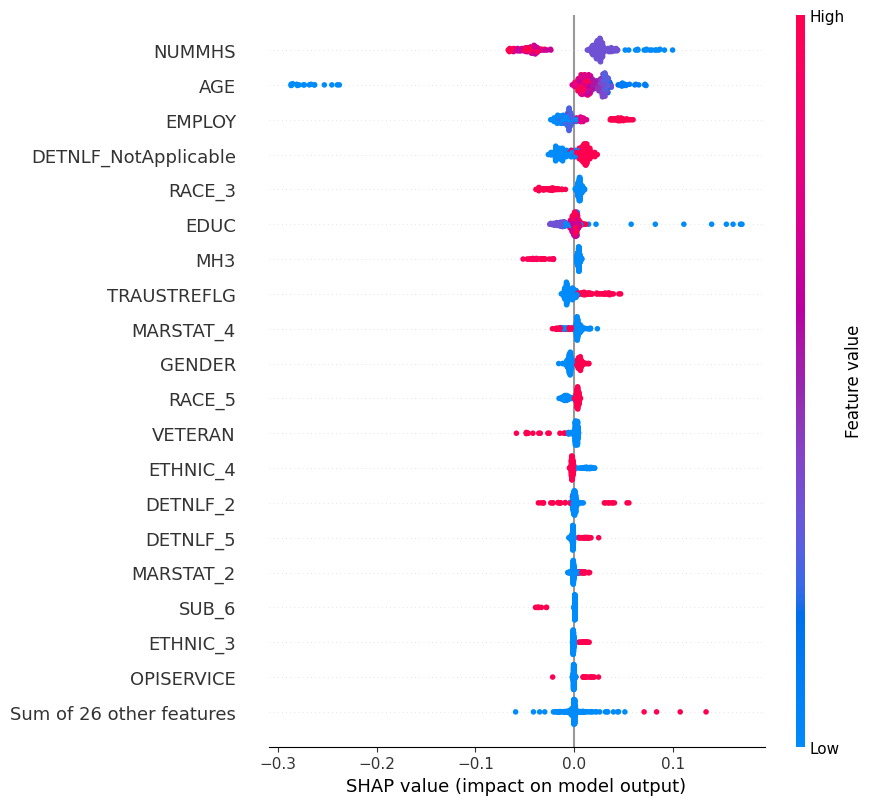

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 지역 변수도 추가로 제거
region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
]

drop_vars = diagnosis_vars + region_vars
df = df.drop(columns=drop_vars, errors='ignore')

# 지역 변수 제거 이후 X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")

X = X.astype({col: int for col in X.select_dtypes('bool').columns})

X = X.drop(columns=X.select_dtypes('object').columns)

X = X.astype(float)
# 랜덤포레스트
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# 예측값 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")

# 11. SHAP
X_sample = X.sample(n=300, random_state=42)
def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.Explainer(predict_proba_fn, X_sample)
shap_values = explainer(X_sample)
class_names = {0: "None", 1: "SMI", 2: "SED"}

# 14. 시각화
for i in range(shap_values.values.shape[2]):
    print(f"{class_names.get(i, str(i))}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20)

In [ ]:
# 클래스0 해당없음 SHAP 값
shap_values_class1 = shap_values[:, :, 0].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.044074
NUMMHS                  0.032779
DETNLF_2                0.019095
EDUC                    0.015436
MARSTAT_4               0.012634
EMPLOY                  0.012478
DETNLF_NotApplicable    0.010871
RACE_3                  0.010538
TRAUSTREFLG             0.008427
MH3                     0.007914
dtype: float64


In [ ]:
# 클래스1 중증 정신질환(SMI) SHAP 값
shap_values_class1 = shap_values[:, :, 1].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.078222
DETNLF_2                0.019183
EDUC                    0.015727
MARSTAT_4               0.008466
MARSTAT_2               0.003890
NUMMHS                  0.003205
EMPLOY                  0.002367
DETNLF_NotApplicable    0.002176
MARSTAT_3               0.001961
VETERAN                 0.001335
dtype: float64


In [ ]:
# 클래스2 심각한 정서장애(SED) SHAP 값
shap_values_class1 = shap_values[:, :, 2].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

NUMMHS                  0.035881
AGE                     0.035186
EMPLOY                  0.013772
DETNLF_NotApplicable    0.011302
RACE_3                  0.009870
EDUC                    0.008660
MH3                     0.008205
TRAUSTREFLG             0.008033
MARSTAT_4               0.005419
GENDER                  0.005227
dtype: float64


### **클래스 0 (해당 없음)**
**AGE, NUMMHS, DETNLF_2, EDUC, MARTAT_4**

연령(많을수록), NUMMHS(적음), DETNLF_2(양호), EDUC(높음), MARSTAT_4(가족이 안정됨)

---

### **클래스1 (SMI)**
**AGE, DETNLF_2, EDUC, MARSTAT_4, MARSTAT_2**

연령(낮음), EDUC(낮음), DETNLF_2(실업), MARSTAT - 가족이 불안정함

---

### **클래스 2 (SED)**
**NUMMHS, AGE, EMPLOY, DETNLF_NotApplicable, RACE_3**

AGE(청소년층), NUMMHS(서비스 다수 이용), EMPLOY(경제활동 미참여), DETNLF_(고용상태 불안정), RACE_3(인종)

### ***XGBOOST : 모든 변수 포함**


랜덤포레스트와의 정확도 비교 위하여 XGBOOST행

In [ ]:
from google.colab import drive
import pandas as pd
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 데이터 다시 불러오기
file_path = '/content/drive/MyDrive/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

# 데이터 처리
df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0),
    axis=1
)
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")

X = X.astype(float)

# XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:35:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8494


In [ ]:
print(type(shap_values))
print(len(shap_values))           # 클래스 개수?
print(shap_values[0].shape)       # 클래스 0에 대한 SHAP 값 shape
print(X_sample.shape)             # 피처 샘플 shape


<class 'numpy.ndarray'>
300
(74, 3)
(300, 74)


<class 'numpy.ndarray'>
300
(74, 3)
(300, 74)

클래스 0 (None)


<ipython-input-90-2016133498>:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


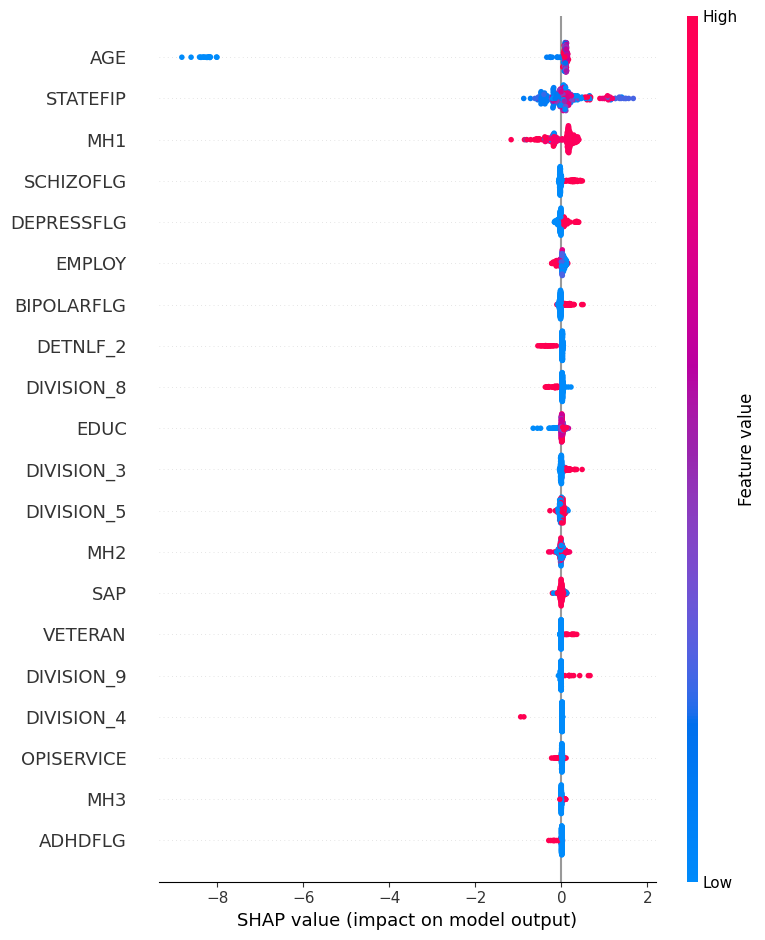


클래스 1 (SMI)


<ipython-input-90-2016133498>:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


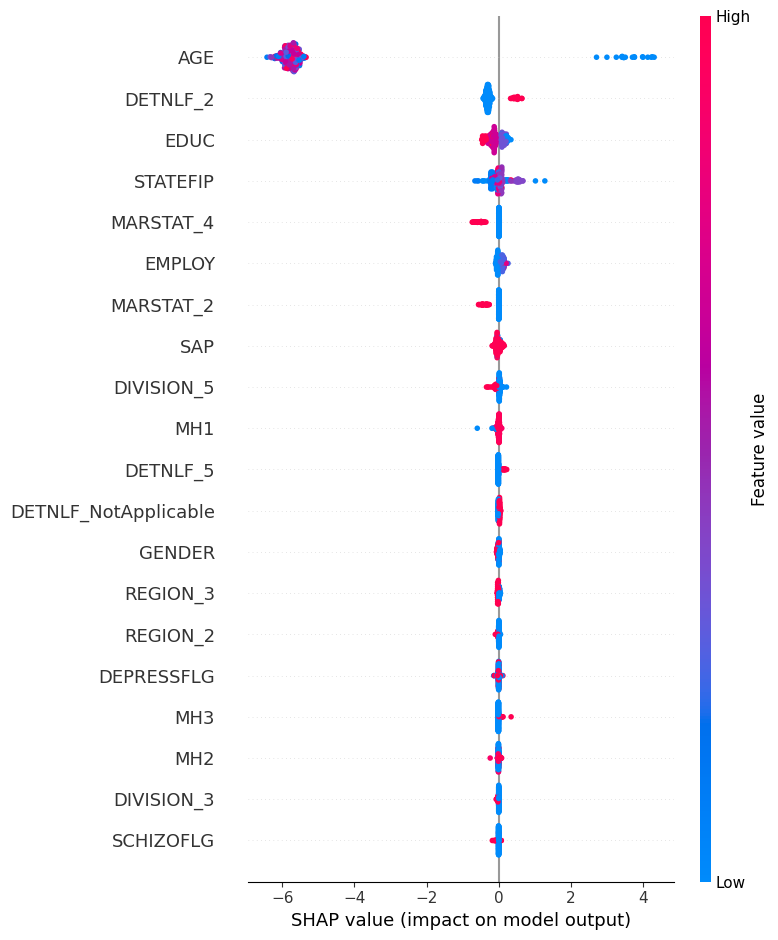


클래스 2 (SED)


<ipython-input-90-2016133498>:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


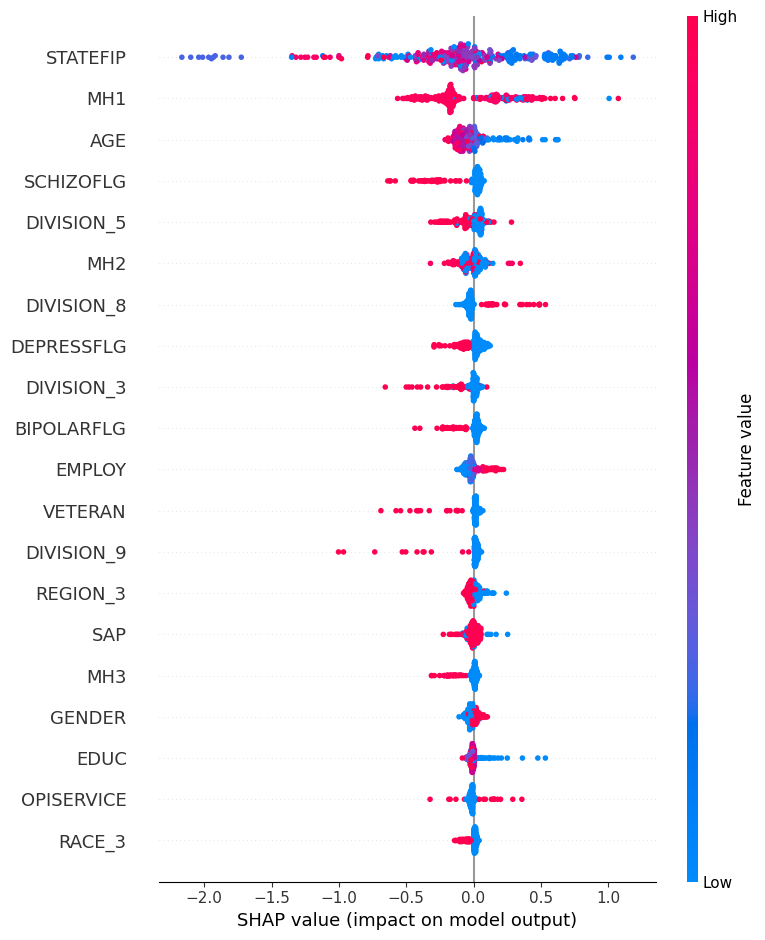

In [ ]:
# SHAP
X_sample = X.sample(n=300, random_state=42)
X_sample = X_sample.loc[:, X.columns]

def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

#  시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(3):  # 3 classes: 0=None, 1=SMI, 2=SED
    print(f"\n클래스 {i} ({class_names[i]})")

    shap_values_class_i = shap_values[:, :, i]

    shap.summary_plot(
        shap_values_class_i,
        features=X_sample,
        feature_names=X_sample.columns,
        plot_type="dot",
        max_display=20
    )


In [ ]:
print((X_sample.size))

22200


In [ ]:
# 클래스0 해당없음 SHAP 값
importance = pd.DataFrame(shap_values[:,:,0], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


AGE           0.570559
STATEFIP      0.293030
MH1           0.230329
SCHIZOFLG     0.069946
DEPRESSFLG    0.054661
EMPLOY        0.052685
BIPOLARFLG    0.050195
DETNLF_2      0.045879
DIVISION_8    0.041741
EDUC          0.037737
dtype: float32


In [ ]:
# 클래스1 중증 정신질환(SMI) SHAP 값
importance = pd.DataFrame(shap_values[:,:,1], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

AGE           5.648525
DETNLF_2      0.313364
EDUC          0.179782
STATEFIP      0.138999
MARSTAT_4     0.100917
EMPLOY        0.076296
MARSTAT_2     0.063513
SAP           0.051864
DIVISION_5    0.044346
MH1           0.022959
dtype: float32


In [ ]:
# 클래스2 심각한 정서장애(SED) SHAP 값
importance = pd.DataFrame(shap_values[:,:,2], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

STATEFIP      0.403794
MH1           0.253603
AGE           0.088795
SCHIZOFLG     0.084895
DIVISION_5    0.060868
MH2           0.055018
DIVISION_8    0.052614
DEPRESSFLG    0.051533
DIVISION_3    0.047415
BIPOLARFLG    0.045978
dtype: float32


### 진단 미포함

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 진단 관련 변수 제거
diagnosis_vars = [
    'MH1', 'MH2', 'SAP',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG',
    'ALCSUBFLG', 'OTHERDISFLG'
]
df = df.drop(columns=diagnosis_vars, errors='ignore')

# X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")
X = X.astype({col: int for col in X.select_dtypes('bool').columns})
X = X.drop(columns=X.select_dtypes('object').columns)
X = X.astype(float)

# XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:15:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8212


<class 'numpy.ndarray'>
300
(59, 3)
(300, 59)

클래스 0 (None)


<ipython-input-97-361062255>:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


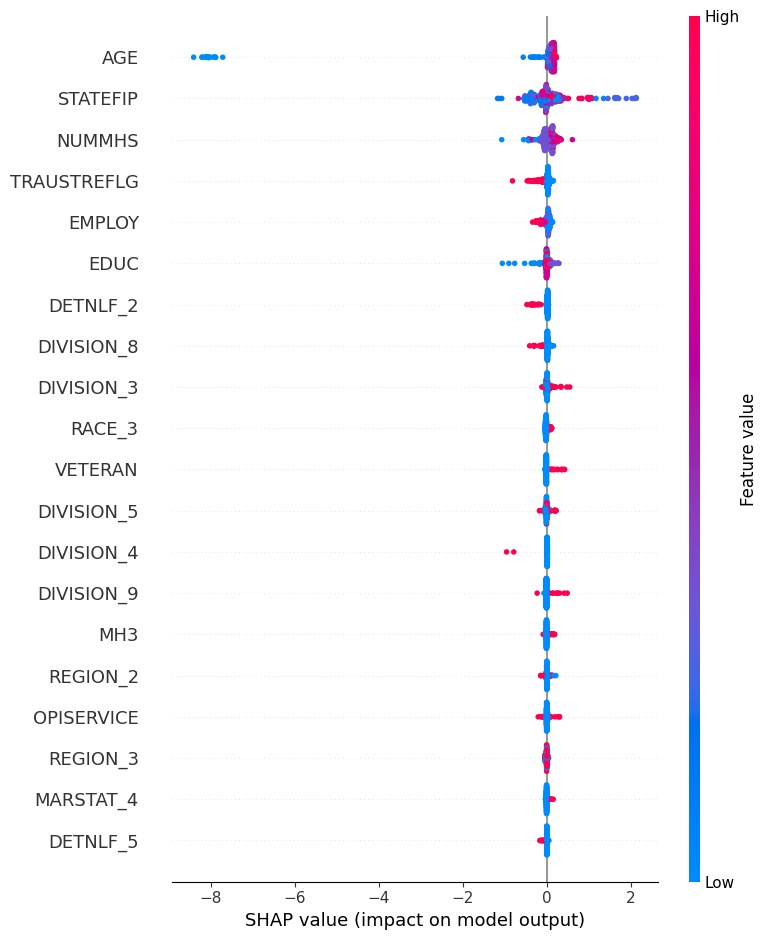


클래스 1 (SMI)


<ipython-input-97-361062255>:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


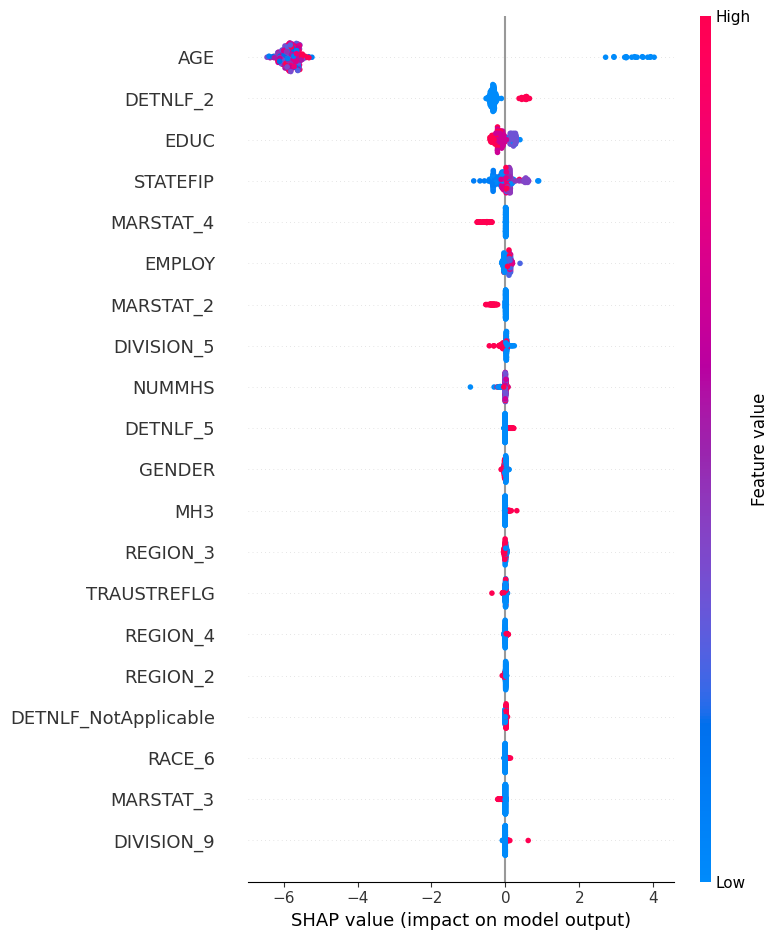


클래스 2 (SED)


<ipython-input-97-361062255>:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


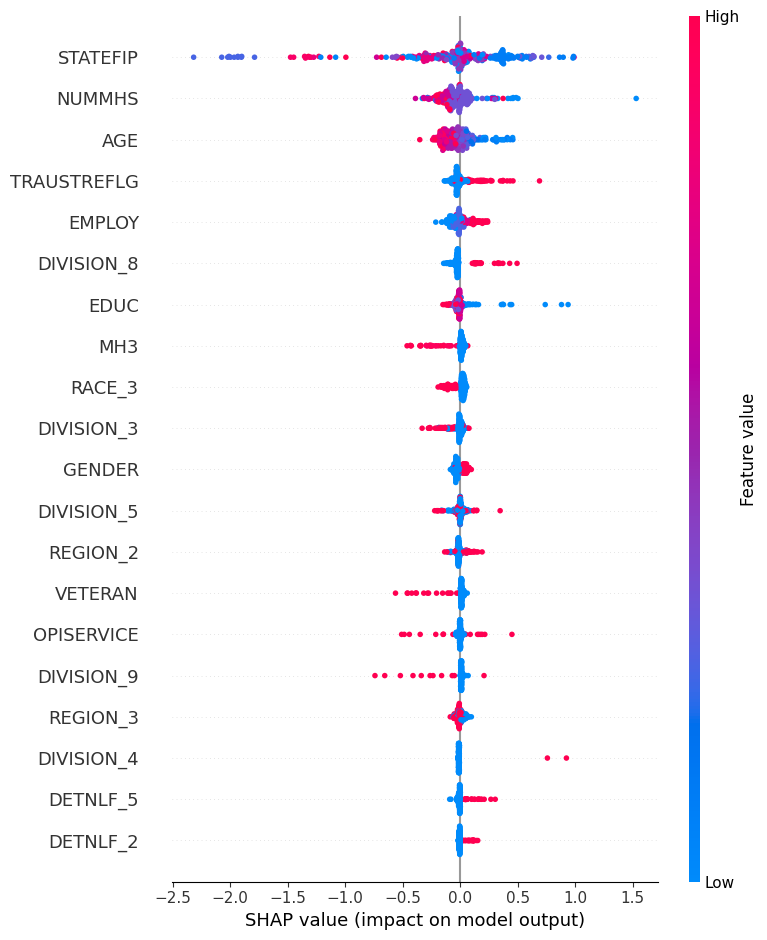

In [ ]:
# SHAP
X_sample = X.sample(n=300, random_state=42)
X_sample = X_sample.loc[:, X.columns]

def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print(type(shap_values))
print(len(shap_values))
print(shap_values[0].shape)
print(X_sample.shape)

#  시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(3):  #
    print(f"\n클래스 {i} ({class_names[i]})")

    shap_values_class_i = shap_values[:, :, i]
    shap.summary_plot(
        shap_values_class_i,
        features=X_sample,
        feature_names=X_sample.columns,
        plot_type="dot",
        max_display=20
    )


In [ ]:
# 클래스0 해당없음 SHAP 값
importance = pd.DataFrame(shap_values[:,:,0], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


AGE            0.573851
STATEFIP       0.287913
NUMMHS         0.121157
TRAUSTREFLG    0.066687
EMPLOY         0.060860
EDUC           0.056033
DETNLF_2       0.042781
DIVISION_8     0.041214
DIVISION_3     0.034355
RACE_3         0.028349
dtype: float32


In [ ]:
# 클래스1 중증 정신질환(SMI) SHAP 값
importance = pd.DataFrame(shap_values[:,:,1], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


AGE           5.684216
DETNLF_2      0.356444
EDUC          0.184529
STATEFIP      0.174430
MARSTAT_4     0.104269
EMPLOY        0.082074
MARSTAT_2     0.058776
DIVISION_5    0.051195
NUMMHS        0.021701
DETNLF_5      0.021205
dtype: float32


In [ ]:
# 클래스2 심각한 정서장애(SED) SHAP 값
importance = pd.DataFrame(shap_values[:,:,2], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

STATEFIP       0.340181
NUMMHS         0.104810
AGE            0.104746
TRAUSTREFLG    0.060142
EMPLOY         0.056771
DIVISION_8     0.054160
EDUC           0.042354
MH3            0.038550
RACE_3         0.037912
DIVISION_3     0.036938
dtype: float32


# **STEP4. 로지스틱 회귀분석**

위에서 분석한 결과 유의미한 변수들만을 가지고 분석을 진행함.

정신질환이 없을 때를 기준으로 중증정신질환과 심각한 정서장애, 2가지에 대해 로그 오즈 변화량을 나타냄.

### 클래스 1
stateip, nummhs, employ, educ, detnlf_2, traustreflg, division_3, race_3 순서로 높게 나타남.

따라서 거주지역, 서비스의 양, 고용 혹은 교육, 인종이 크게 의미를 가진다는 것을 볼 수 있음

SHAP으로 분석한 것과 다르게 연령이 큰 영향을 미치지 않음.

### 클래스 2
age, nummhs, employ, educ, detnlf_2, division_8, race_3, stateip, traustreflg 기준으로 높게 나타남

따라서 청소년, 교육ㅇ 부족, 경제활동을 하지 않음, 특정 지역과 연관되어 있을 때 의미를 가짐.

연령이 유의미한 결과를 미침.



In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0),
    axis=1
)
y = df["SMISED"]

diagnosis_vars = [
    'MH1', 'MH2', 'MH3', 'SAP',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG',
    'ALCSUBFLG', 'OTHERDISFLG'
]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"] + diagnosis_vars, errors='ignore')

# shap 결과 반영. 주요 변수만
selected_vars = [
    'AGE', 'STATEFIP', 'NUMMHS', 'TRAUSTREFLG', 'EMPLOY',
    'EDUC', 'DETNLF_2', 'DIVISION_8', 'DIVISION_3', 'RACE_3'
]
X = X[selected_vars]

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=selected_vars)
X_scaled = sm.add_constant(X_scaled)

# 로지스틱 회
model = sm.MNLogit(y, X_scaled)
result = model.fit()

# 결과 출력
print(result.summary())


         Current function value: 0.532788
         Iterations: 35


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          MNLogit Regression Results                          
Dep. Variable:                 SMISED   No. Observations:              1147781
Model:                        MNLogit   Df Residuals:                  1147759
Method:                           MLE   Df Model:                           20
Date:                Wed, 11 Jun 2025   Pseudo R-squ.:                  0.2144
Time:                        10:31:47   Log-Likelihood:            -6.1152e+05
converged:                      False   LL-Null:                   -7.7842e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
   SMISED=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -167.8254   5.67e+04     -0.003      0.998   -1.11e+05    1.11e+05
AGE           -96.5525   3.24e+04     -0.003      0.998   -6.36e+04    6.34e+04
STATEFIP        0.3274      0.009     35.843    

In [ ]:
print(result.params.columns)


RangeIndex(start=0, stop=2, step=1)
